# Analysis of Accelerator-VC Bipartite Networks

Analysis of the USA accelerator-VC network using ecological metrics inspired by Theo's work on complex networks in entrepreneurial ecosystems.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import sys

sys.path.append('../../') 

# Import custom modules
from utils.data_cleaning import *
from utils.data_extraction import *
from utils.network_analysis import *

plt.style.use('default')
sns.set_palette('husl')

## Data Loading and Preparation

In [5]:
country = "france"
data_dir = f'../../data/{country}'

cleaned_data = load_clean_data(data_dir)

companies_clean = cleaned_data['companies']
investors_clean = cleaned_data['investors']
investments_clean = cleaned_data['investments']
funding_rounds_clean = cleaned_data['funding_rounds']

print(f"After cleaning:")
print(f"Companies: {len(companies_clean):,}")
print(f"Investors: {len(investors_clean):,}")
print(f"Investments: {len(investments_clean):,}")
print(f"Funding rounds: {len(funding_rounds_clean):,}")

After cleaning:
Companies: 2,361
Investors: 4,564
Investments: 10,163
Funding rounds: 14,375


## VC-VC Network Construction

In [6]:
vc_investments = extract_vc_investments(cleaned_data['investments'])

print("\nSample of VC investments:")
if 'company_name' in vc_investments.columns:
    display_cols = ['company_name', 'investor_name', 'investor_types', 'total_funding_usd']
    print(vc_investments[display_cols].head())
else:
    print(vc_investments[['org_uuid', 'investor_name', 'investor_types']].head())
    
vc_investments = extract_vc_investments(cleaned_data['investments'])

print("\nSample of VC investments:")
if 'company_name' in vc_investments.columns:
    display_cols = ['company_name', 'investor_name', 'investor_types', 'total_funding_usd']
    print(vc_investments[display_cols].head())
else:
    print(vc_investments[['org_uuid', 'investor_name', 'investor_types']].head())
    
print("\VC-VC pairs:")
vc_vc_investments_pairs = create_investment_pairs(vc_investments, vc_investments, 'left_vc', 'right_vc')
vc_vc_investments_pairs['announced_year'] = vc_vc_investments_pairs[['announced_year_left_vc', 'announced_year_right_vc']].max(axis=1)
vc_vc_investments_pairs['total_funding_usd'] = (
    vc_vc_investments_pairs['total_funding_usd_left_vc']
    + vc_vc_investments_pairs['total_funding_usd_right_vc']
)
print(vc_vc_investments_pairs[['org_uuid', 'investor_name_left_vc', 'investor_name_right_vc']].head())

Found 5705 VC investments
Unique companies with VC funding: 1835

Sample of VC investments:
           company_name      investor_name  \
0                TVtrip  Balderton Capital   
1                TVtrip            Partech   
2                Twenga           3i Group   
4                 MyFab              Alven   
6  Inspirational Stores      Atlas Venture   

                        investor_types  total_funding_usd  
0                      venture capital         13770000.0  
1                      venture capital         13770000.0  
2  private equity firm,venture capital         14790959.0  
4                      venture capital         10176279.0  
6                      venture capital         11470000.0  
Found 5705 VC investments
Unique companies with VC funding: 1835

Sample of VC investments:
           company_name      investor_name  \
0                TVtrip  Balderton Capital   
1                TVtrip            Partech   
2                Twenga           3i Grou

## Static Ecological Network Analysis

Analysis using ecological metrics inspired by Carniel's framework.

In [7]:

# Analyze VC-VC network structure for comparison
vc_vc_edges = extract_bipartite_edges_from_pairs(
    vc_vc_investments_pairs,
    'investor_name_left_vc',
    'investor_name_right_vc',
    'total_funding_usd'
)

print(f"VC-VC Co-investment Network Statistics:")
print(f"  Unique VC partnerships: {len(vc_vc_edges):,}")
print(f"  Total syndicated funding: ${vc_vc_edges['total_funding_usd'].sum():,.0f}")

# Create simple graph (not bipartite)
G_vc = nx.Graph()
for _, row in vc_vc_edges.iterrows():
    G_vc.add_edge(row['investor_name_left_vc'], row['investor_name_right_vc'], 
                  weight=row['total_funding_usd'])
    
print(f"\nVC-VC Network Structure:")
print(f"  Unique VCs: {G_vc.number_of_nodes():,}")
print(f"  Partnership edges: {G_vc.number_of_edges():,}")
print(f"  Network density: {nx.density(G_vc):.6f}")
print(f"  Connected components: {nx.number_connected_components(G_vc)}")
print(f"  Density: {nx.density(G_vc)}")

VC-VC Co-investment Network Statistics:
  Unique VC partnerships: 13,540
  Total syndicated funding: $16,076,054,328,590

VC-VC Network Structure:
  Unique VCs: 1,180
  Partnership edges: 7,360
  Network density: 0.010581
  Connected components: 125
  Density: 0.010580641451387991


#### Comments

...

## Time Series Ecological Network Analysis

In [8]:
# Extract year from funding rounds for time series analysis
# Merge investment data with funding rounds to get temporal information
vc_vc_inv_pairs_ts = vc_vc_investments_pairs.copy()

# Convert to datetime and extract year
# vc_vc_inv_pairs_ts['announced_year'] = pd.to_datetime(vc_vc_inv_pairs_ts['announced_year'])
vc_vc_inv_pairs_ts['year'] = vc_vc_inv_pairs_ts['announced_year']

# Get the range of years
min_year = 2011
max_year = 2023

# Filter out rows with missing dates
vc_vc_inv_pairs_ts = vc_vc_inv_pairs_ts.dropna(subset=['year'])
vc_vc_inv_pairs_ts = vc_vc_inv_pairs_ts[(vc_vc_inv_pairs_ts['year'] >= min_year) & (vc_vc_inv_pairs_ts['year'] <= max_year)]


print(f"Time series analysis from {min_year} to {max_year}")
print(f"Total investments with dates: {len(vc_vc_inv_pairs_ts):,}")

# Show distribution by year
year_counts = vc_vc_inv_pairs_ts['year'].value_counts().sort_index()
print(f"\nInvestments per year:")
print(year_counts)

Time series analysis from 2011 to 2023
Total investments with dates: 38,719

Investments per year:
year
2011     207
2012     711
2013     568
2014     911
2015    1947
2016    1374
2017    2417
2018    3030
2019    4340
2020    3665
2021    7831
2022    6856
2023    4862
Name: count, dtype: int64


### Snapshot-based analysis

In [9]:
# Initialize storage for time series metrics
time_series_metrics = []

# Minimum number of edges required for meaningful analysis
min_edges_threshold = 10

print("Computing ecological metrics for each year...")
print("=" * 50)

# Loop through each year and calculate metrics
for year in range(min_year, max_year + 1):
    cur_year_pairs = vc_vc_inv_pairs_ts[vc_vc_inv_pairs_ts['year'] == year]

    if len(cur_year_pairs) < min_edges_threshold:
        print(f"Year {year}: Skipping (only {len(cur_year_pairs)} investments)")
        continue
    
    try:
        # Extract bipartite edges for this year
        year_edges = extract_bipartite_edges_from_pairs(
            cur_year_pairs,
            'investor_name_left_vc',
            'investor_name_right_vc',
            'total_funding_usd'
        )

        curr_G_vc = nx.Graph()

        for _, row in year_edges.iterrows():
            curr_G_vc.add_edge(row['investor_name_left_vc'], row['investor_name_right_vc'], 
                        weight=row['total_funding_usd'])
    
        
        print(f"\nVC-VC Network Structure:")
        print(f"  Unique VCs: {curr_G_vc.number_of_nodes():,}")
        print(f"  Partnership edges: {curr_G_vc.number_of_edges():,}")
        print(f"  Network density: {nx.density(curr_G_vc):.6f}")
        print(f"  Connected components: {nx.number_connected_components(curr_G_vc)}")
        print(f"  Density: {nx.density(curr_G_vc)}")
        
        # Store metrics for this year
        year_metrics = {
            'year': year,
            'num_nodes': curr_G_vc.number_of_nodes(),
            'num_edges': curr_G_vc.number_of_edges(),
            'connectance': nx.density(curr_G_vc),
            'num_components': nx.number_connected_components(curr_G_vc)
        }
        
        time_series_metrics.append(year_metrics)
        
        print(f"Year {year}: {year_metrics['num_nodes']} nodes, {year_metrics['num_edges']} edges, "
              f"Connectance: {year_metrics['connectance']:.3f}, "
              f"Components: {year_metrics['num_components']:.1f}, ")
        
    except Exception as e:
        print(f"Year {year}: Error - {str(e)}")
        continue

print(f"\nSuccessfully analyzed {len(time_series_metrics)} years")

Computing ecological metrics for each year...

VC-VC Network Structure:
  Unique VCs: 58
  Partnership edges: 87
  Network density: 0.052632
  Connected components: 33
  Density: 0.05263157894736842
Year 2011: 58 nodes, 87 edges, Connectance: 0.053, Components: 33.0, 

VC-VC Network Structure:
  Unique VCs: 81
  Partnership edges: 190
  Network density: 0.058642
  Connected components: 32
  Density: 0.05864197530864197
Year 2012: 81 nodes, 190 edges, Connectance: 0.059, Components: 32.0, 

VC-VC Network Structure:
  Unique VCs: 101
  Partnership edges: 207
  Network density: 0.040990
  Connected components: 38
  Density: 0.04099009900990099
Year 2013: 101 nodes, 207 edges, Connectance: 0.041, Components: 38.0, 

VC-VC Network Structure:
  Unique VCs: 149
  Partnership edges: 330
  Network density: 0.029929
  Connected components: 38
  Density: 0.02992925811717758
Year 2014: 149 nodes, 330 edges, Connectance: 0.030, Components: 38.0, 

VC-VC Network Structure:
  Unique VCs: 210
  Partne

In [10]:
# Convert to DataFrame for easier analysis and plotting
ts_df = pd.DataFrame(time_series_metrics)

if len(ts_df) > 0:
    print("Time Series Metrics Summary:")
    print(ts_df.describe().round(3))
    
    print(f"\nData available for years: {ts_df['year'].min()} to {ts_df['year'].max()}")
    print(f"Number of years analyzed: {len(ts_df)}")
else:
    print("No time series data available for analysis")

Time Series Metrics Summary:
           year  num_nodes  num_edges  connectance  num_components
count    13.000     13.000     13.000       13.000          13.000
mean   2017.000    249.846    826.385        0.029          41.000
std       3.894    129.246    611.699        0.013           7.832
min    2011.000     58.000     87.000        0.019          27.000
25%    2014.000    149.000    330.000        0.020          36.000
50%    2017.000    262.000    670.000        0.021          42.000
75%    2020.000    350.000   1165.000        0.030          48.000
max    2023.000    451.000   2040.000        0.059          54.000

Data available for years: 2011 to 2023
Number of years analyzed: 13


Evolution of ecological metrics over time in the accelerator-VC ecosystem.

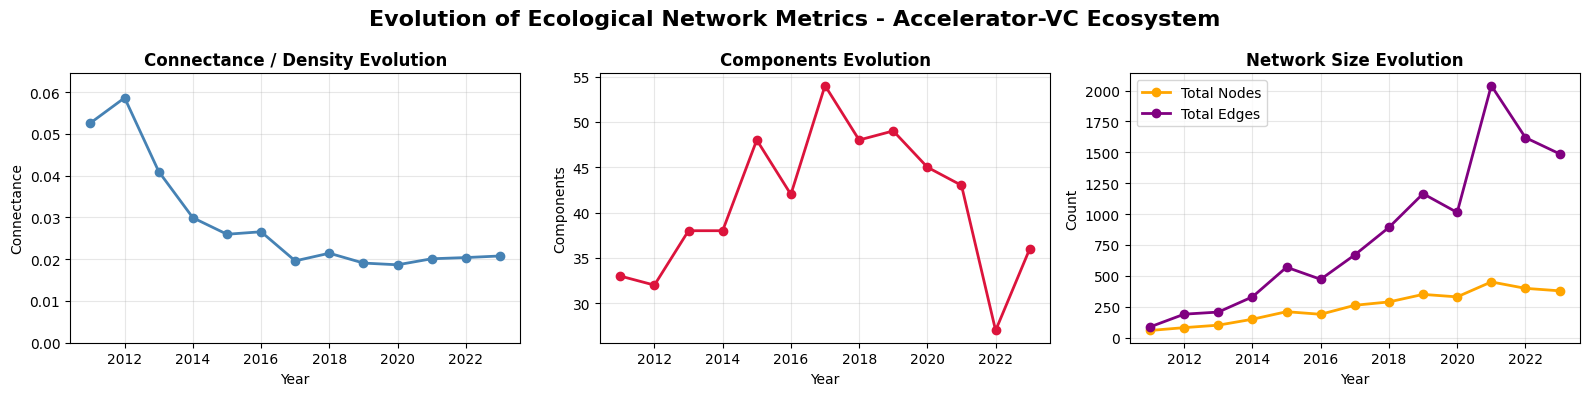

In [11]:
if len(ts_df) > 0:
    # Create comprehensive time series plot
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    fig.suptitle('Evolution of Ecological Network Metrics - Accelerator-VC Ecosystem', 
                 fontsize=16, fontweight='bold')
    
    # Connectance evolution
    axes[0].plot(ts_df['year'], ts_df['connectance'], 'o-', linewidth=2, markersize=6, color='steelblue')
    axes[0].set_title('Connectance / Density Evolution', fontweight='bold')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Connectance')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, max(ts_df['connectance']) * 1.1)
    
    """ # Nestedness evolution
    axes[0, 1].plot(ts_df['year'], ts_df['nestedness_nodf'], 'o-', linewidth=2, markersize=6, color='forestgreen')
    axes[0, 1].set_title('Nestedness (NODF) Evolution', fontweight='bold')
    axes[0, 1].set_xlabel('Year')
    axes[0, 1].set_ylabel('Nestedness (NODF)')
    axes[0, 1].grid(True, alpha=0.3) """
    
    # Modularity evolution
    axes[1].plot(ts_df['year'], ts_df['num_components'], 'o-', linewidth=2, markersize=6, color='crimson')
    axes[1].set_title('Components Evolution', fontweight='bold')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Components')
    axes[1].grid(True, alpha=0.3)
    
    # Network size evolution
    axes[2].plot(ts_df['year'], ts_df['num_nodes'], 'o-', linewidth=2, markersize=6, color='orange', label='Total Nodes')
    axes[2].plot(ts_df['year'], ts_df['num_edges'], 'o-', linewidth=2, markersize=6, color='purple', label='Total Edges')
    axes[2].set_title('Network Size Evolution', fontweight='bold')
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('Count')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for time series visualization")

=== Temporal Trends Analysis ===

Year-over-Year Changes (average):
connectance: -0.0027 per year (total: -0.0319)
num_components: +0.2500 per year (total: +3.0000)
num_nodes: +26.7500 per year (total: +321.0000)
num_edges: +116.7500 per year (total: +1401.0000)


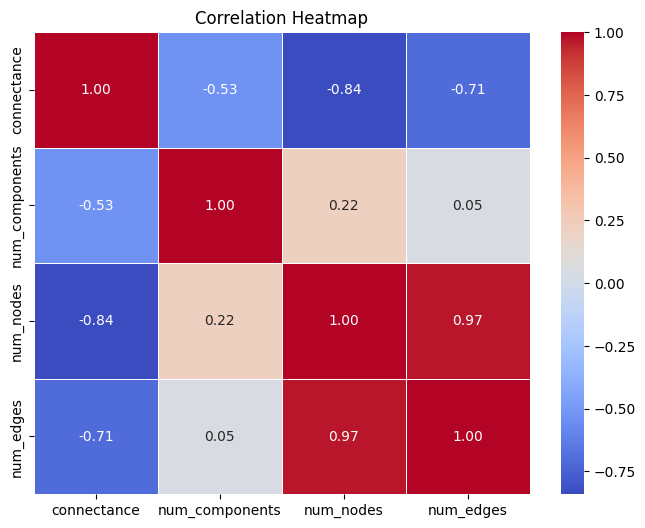

In [12]:
if len(ts_df) > 1:
    # Calculate trends and correlations
    print("=== Temporal Trends Analysis ===")
    
    # Calculate year-over-year changes
    ts_df_sorted = ts_df.sort_values('year')
    
    metrics_to_analyze = ['connectance', 'num_components', 'num_nodes', 'num_edges']
    
    print("\nYear-over-Year Changes (average):")
    for metric in metrics_to_analyze:
        if metric in ts_df_sorted.columns:
            # Calculate differences
            diffs = ts_df_sorted[metric].diff().dropna()
            avg_change = diffs.mean()
            total_change = ts_df_sorted[metric].iloc[-1] - ts_df_sorted[metric].iloc[0]
            print(f"{metric}: {avg_change:+.4f} per year (total: {total_change:+.4f})")
            
    matrix = ts_df_sorted[metrics_to_analyze].corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()

else:
    print("Insufficient data for temporal trends analysis (need at least 2 years)")

### Cumulative network analysis (5 years window)

In [13]:
# Initialize storage for time series metrics
ts_cumulative_metrics = []
cumulative_window = 5

# Minimum number of edges required for meaningful analysis
min_edges_threshold = 10

print(f"Computing ecological metrics for each year ({cumulative_window} years window)...")
print("=" * 50)

# Loop through each year and calculate metrics
for year in range(min_year, max_year + 1):
    cur_window_acc_vc_inv_pairs = vc_vc_inv_pairs_ts[(vc_vc_inv_pairs_ts['year'] >= year) & (vc_vc_inv_pairs_ts['year'] >= year - cumulative_window)]
    
    try:
        window_edges = extract_bipartite_edges_from_pairs(
            cur_window_acc_vc_inv_pairs,
            'investor_name_left_vc',
            'investor_name_right_vc',
            'total_funding_usd'
        )

        curr_G_vc = nx.Graph()

        for _, row in window_edges.iterrows():
            curr_G_vc.add_edge(row['investor_name_left_vc'], row['investor_name_right_vc'], 
                        weight=row['total_funding_usd'])
    
        
        print(f"\nVC-VC Network Structure:")
        print(f"  Unique VCs: {curr_G_vc.number_of_nodes():,}")
        print(f"  Partnership edges: {curr_G_vc.number_of_edges():,}")
        print(f"  Network density: {nx.density(curr_G_vc):.6f}")
        print(f"  Connected components: {nx.number_connected_components(curr_G_vc)}")
        print(f"  Density: {nx.density(curr_G_vc)}")
        
        # Store metrics for this year
        year_metrics = {
            'year': year,
            'num_nodes': curr_G_vc.number_of_nodes(),
            'num_edges': curr_G_vc.number_of_edges(),
            'connectance': nx.density(curr_G_vc),
            'num_components': nx.number_connected_components(curr_G_vc)
        }
        
        ts_cumulative_metrics.append(year_metrics)
        
        print(f"Year {year}: {year_metrics['num_nodes']} nodes, {year_metrics['num_edges']} edges, "
              f"Connectance: {year_metrics['connectance']:.3f}, "
              f"Components: {year_metrics['num_components']:.1f}, ")
        
    except Exception as e:
        print(f"Year {year}: Error - {str(e)}")
        continue

print(f"\nSuccessfully analyzed {len(ts_cumulative_metrics)} years")

Computing ecological metrics for each year (5 years window)...

VC-VC Network Structure:
  Unique VCs: 1,054
  Partnership edges: 6,606
  Network density: 0.011904
  Connected components: 110
  Density: 0.011904182682171296
Year 2011: 1054 nodes, 6606 edges, Connectance: 0.012, Components: 110.0, 

VC-VC Network Structure:
  Unique VCs: 1,051
  Partnership edges: 6,581
  Network density: 0.011927
  Connected components: 109
  Density: 0.011926962983099995
Year 2012: 1051 nodes, 6581 edges, Connectance: 0.012, Components: 109.0, 

VC-VC Network Structure:
  Unique VCs: 1,044
  Partnership edges: 6,532
  Network density: 0.011998
  Connected components: 107
  Density: 0.011997516741788901
Year 2013: 1044 nodes, 6532 edges, Connectance: 0.012, Components: 107.0, 

VC-VC Network Structure:
  Unique VCs: 1,033
  Partnership edges: 6,459
  Network density: 0.012118
  Connected components: 106
  Density: 0.01211756230441928
Year 2014: 1033 nodes, 6459 edges, Connectance: 0.012, Components: 10

In [14]:
# Convert to DataFrame for easier analysis and plotting
ts_cumulative_df = pd.DataFrame(ts_cumulative_metrics)

if len(ts_cumulative_df) > 0:
    print("Time Series Metrics Summary:")
    print(ts_cumulative_df.describe().round(3))
    
    print(f"\nData available for years: {ts_cumulative_df['year'].min()} to {ts_cumulative_df['year'].max()}")
    print(f"Number of years analyzed: {len(ts_cumulative_df)}")
else:
    print("No time series data available for analysis")

Time Series Metrics Summary:
           year  num_nodes  num_edges  connectance  num_components
count    13.000     13.000     13.000       13.000          13.000
mean   2017.000    882.692   5306.692        0.014          81.538
std       3.894    202.745   1575.722        0.002          26.635
min    2011.000    379.000   1488.000        0.012          36.000
25%    2014.000    822.000   4800.000        0.012          61.000
50%    2017.000    955.000   5898.000        0.013          91.000
75%    2020.000   1033.000   6459.000        0.014         106.000
max    2023.000   1054.000   6606.000        0.021         110.000

Data available for years: 2011 to 2023
Number of years analyzed: 13


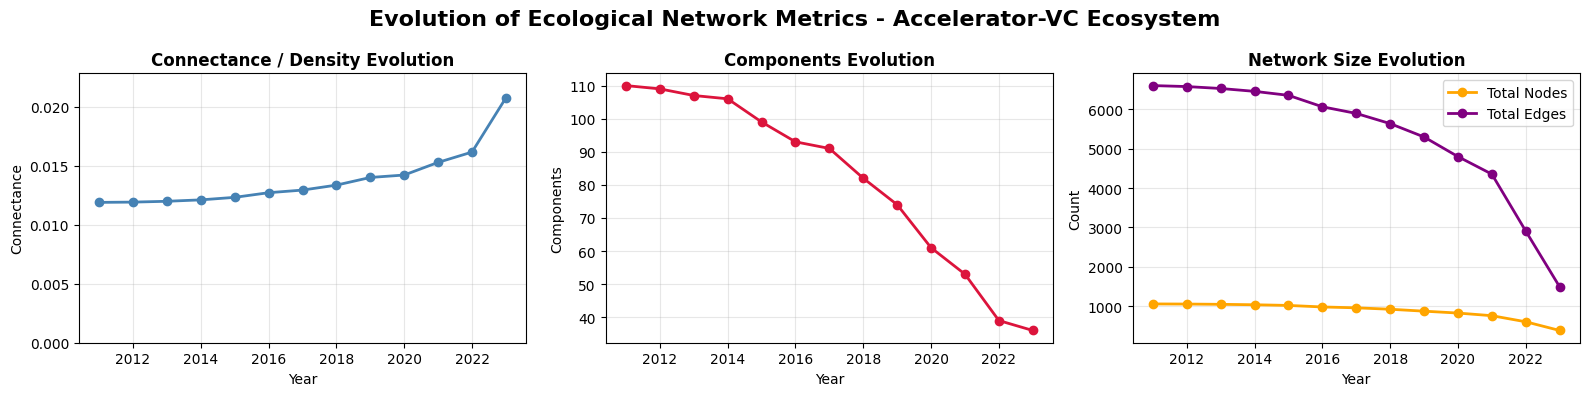

In [15]:
if len(ts_cumulative_df) > 0:
    # Create comprehensive time series plot
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    fig.suptitle('Evolution of Ecological Network Metrics - Accelerator-VC Ecosystem', 
                 fontsize=16, fontweight='bold')
    
    # Connectance evolution
    axes[0].plot(ts_cumulative_df['year'], ts_cumulative_df['connectance'], 'o-', linewidth=2, markersize=6, color='steelblue')
    axes[0].set_title('Connectance / Density Evolution', fontweight='bold')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Connectance')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, max(ts_cumulative_df['connectance']) * 1.1)
    
    # Nestedness evolution
    """ axes[0, 1].plot(ts_cumulative_df['year'], ts_cumulative_df['nestedness_nodf'], 'o-', linewidth=2, markersize=6, color='forestgreen')
    axes[0, 1].set_title('Nestedness (NODF) Evolution', fontweight='bold')
    axes[0, 1].set_xlabel('Year')
    axes[0, 1].set_ylabel('Nestedness (NODF)')
    axes[0, 1].grid(True, alpha=0.3) """
    
    # Modularity evolution
    axes[1].plot(ts_cumulative_df['year'], ts_cumulative_df['num_components'], 'o-', linewidth=2, markersize=6, color='crimson')
    axes[1].set_title('Components Evolution', fontweight='bold')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Components')
    axes[1].grid(True, alpha=0.3)
    
    # Network size evolution
    axes[2].plot(ts_cumulative_df['year'], ts_cumulative_df['num_nodes'], 'o-', linewidth=2, markersize=6, color='orange', label='Total Nodes')
    axes[2].plot(ts_cumulative_df['year'], ts_cumulative_df['num_edges'], 'o-', linewidth=2, markersize=6, color='purple', label='Total Edges')
    axes[2].set_title('Network Size Evolution', fontweight='bold')
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('Count')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    """ axes[2, 0].plot(ts_cumulative_df['year'], ts_cumulative_df['num_accelerators'], 'o-', linewidth=2, markersize=6, 
                color='lightblue', label='Accelerators')
    axes[2, 0].plot(ts_cumulative_df['year'], ts_cumulative_df['num_vcs'], 'o-', linewidth=2, markersize=6, 
                color='lightcoral', label='VCs')
    axes[2, 0].set_title('Accelerators vs VCs Over Time', fontweight='bold')
    axes[2, 0].set_xlabel('Year')
    axes[2, 0].set_ylabel('Number of Actors')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3) """
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for time series visualization")

=== Temporal Trends Analysis ===

Year-over-Year Changes (average):
connectance: +0.0007 per year (total: +0.0089)
num_components: -6.1667 per year (total: -74.0000)
num_nodes: -56.2500 per year (total: -675.0000)
num_edges: -426.5000 per year (total: -5118.0000)


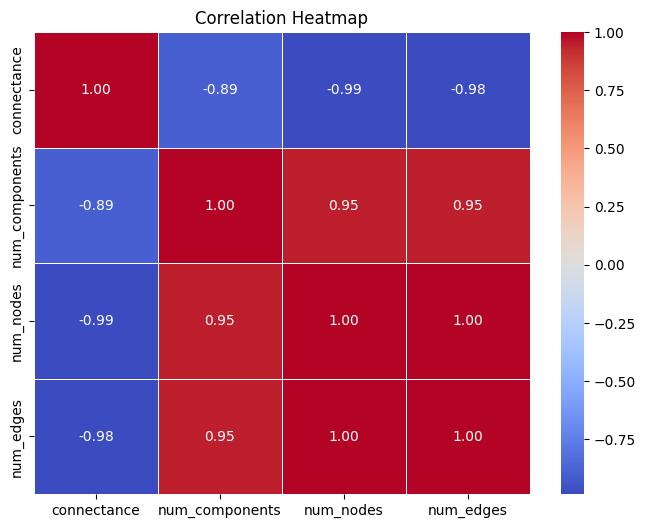

In [16]:
if len(ts_cumulative_df) > 1:
    # Calculate trends and correlations
    print("=== Temporal Trends Analysis ===")
    
    # Calculate year-over-year changes
    ts_cumulative_df_sorted = ts_cumulative_df.sort_values('year')
    
    cumulative_metrics_to_analyze = ['connectance', 'num_components', 'num_nodes', 'num_edges']
    
    print("\nYear-over-Year Changes (average):")
    for metric in cumulative_metrics_to_analyze:
        if metric in ts_cumulative_df_sorted.columns:
            # Calculate differences
            diffs = ts_cumulative_df_sorted[metric].diff().dropna()
            avg_change = diffs.mean()
            total_change = ts_cumulative_df_sorted[metric].iloc[-1] - ts_cumulative_df_sorted[metric].iloc[0]
            print(f"{metric}: {avg_change:+.4f} per year (total: {total_change:+.4f})")
    
    cum_matrix = ts_cumulative_df_sorted[cumulative_metrics_to_analyze].corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(cum_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()

else:
    print("Insufficient data for temporal trends analysis (need at least 2 years)")